In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import os

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42

# 현재 device 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
DATA_PATH = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [5]:
DATA_PATH_model = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [6]:
df = pd.read_csv(f"{DATA_PATH}train_emotion.csv")
df

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,시원하고 좋은데 뾰루지 많이나고 따갑네요,1,23.09.07.,라보에이치,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,저랑은 안맞네요 계속 쓰다보니 두피 너무 가렵고 비듬각질이 생기네요,1,23.02.18.,라보에이치,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,효과는없고 계속많이빠져요,1,22.07.27.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,"제품이 어떤지는 잘 모르겠고요, 아모레퍼시픽이 소비자 생각 안 하는 회사인 건 확실...",1,22.04.05.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,ㅋㅋ최악이에요 진짜.. 3월1일에 주문했는데 3월 30일인 오늘 도착했네요 그냥 취...,1,22.03.30.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4731,머리빠짐이 덜한것 같은데 일단 더 사용해 볼게요~ 무엇보다 샴푸를 쓰고 나면 타샴푸...,5,21.11.25.,반코르,NaN,NaN,1.0,1.0,NaN,NaN,1.0
4732,확실히 기름기랑 두피여드름이 줄었어요,5,22.01.12.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4733,1. 머리 덜 간지러움 2. 각질 비듬 줄어듬 3. 머리카락이 두꺼워지는게 느껴짐 ...,5,21.12.12.,반코르,NaN,NaN,NaN,1.0,NaN,1.0,NaN
4734,지성두피라서 오후만 되면 앞머리 떡지던 사람으로서 이정도로 만족스러운 샴푸는 처음입...,5,21.12.01.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [7]:
df = df.dropna(subset='머릿결*', axis=0).reset_index(drop=True)

In [8]:
df

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,저한테는 안맞는거 같아요 처음에는 써보니 머릿결도 부드러워 지고 만족스러웠는데 2주...,1,21.01.12.,이지마인드,NaN,NaN,NaN,0.0,NaN,NaN,1.0
1,탈모샴푸인데 모발이 부드러워요,2,21.11.25.,라보에이치,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,머리가 찰랑거리는 느낌이 아니구 무거움,2,20.10.06.,라보에이치,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,솔직히 이 샴푸써도 머리 빠지는건 똑같은거 같구 ... 박하향때문에 두피가 시원하긴...,2,20.09.16.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,머리카락이 안뻑뻑하고 부드러워요 그것빼곤 별로입니다 두피가 간지럽고 헹굴때도 머리카...,2,20.09.23.,라보에이치,NaN,NaN,NaN,0.0,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
851,머리카락이 너무 빠져서 서치 끝에 찾게된 반코르 확실히 빠지는게 덜합니다 머리숱은 ...,5,21.12.10.,반코르,NaN,0.0,NaN,NaN,NaN,1.0,1.0
852,머릿결 부드러워지고 진짜 기름기가 확줄었어료,5,22.01.04.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0
853,아주 만족스럽습니다 머릿결이 강해졋어요,5,22.01.15.,반코르,NaN,NaN,NaN,NaN,NaN,NaN,1.0
854,머리빠짐이 덜한것 같은데 일단 더 사용해 볼게요~ 무엇보다 샴푸를 쓰고 나면 타샴푸...,5,21.11.25.,반코르,NaN,NaN,1.0,1.0,NaN,NaN,1.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   content      856 non-null    object 
 1   score        856 non-null    int64  
 2   date         856 non-null    object 
 3   brand        856 non-null    object 
 4   가격           108 non-null    float64
 5   세정력/거품       328 non-null    float64
 6   향기           200 non-null    float64
 7   트러블/진정       214 non-null    float64
 8   배송/서비스/고객대응  45 non-null     float64
 9   탈모 효과 및 쿨링감  167 non-null    float64
 10  머릿결*         856 non-null    float64
dtypes: float64(7), int64(1), object(3)
memory usage: 73.7+ KB


In [10]:
target = df.iloc[:,10].to_numpy().reshape(-1,1)
target

array([[1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [11]:
target = (target == 0).astype(int)

In [12]:
model_name = "jaehyeong/koelectra-base-v3-generalized-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [13]:
train_token = tokenizer(df['content'].tolist(), padding="max_length", max_length=512, truncation=True)

In [14]:
input_ids = np.array(train_token['input_ids'])
attention_mask = np.array(train_token['attention_mask'])
token_type_ids = np.array(train_token['token_type_ids'])

input_ids.shape, attention_mask.shape, token_type_ids.shape

((856, 512), (856, 512), (856, 512))

In [15]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, token_type_ids, y_1=None, y_2=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.y_1 = y_1


    def __len__(self):
        return self.input_ids.shape[0]

    def __getitem__(self, idx):
        item = {}
        item['input_ids'] = torch.tensor(self.input_ids[idx])
        item['attention_mask'] = torch.tensor(self.attention_mask[idx])
        item['token_type_ids'] = torch.tensor(self.token_type_ids[idx])
        if self.y_1 is not None:
            item['y_1'] = torch.Tensor(self.y_1[idx])

        return item

In [16]:
class Net(torch.nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.output_layer = torch.nn.Linear( self.model.config.hidden_size , 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        x = self.model(input_ids, attention_mask, token_type_ids)
        x = self.output_layer(x[0][:,0])
        return x

In [17]:
def train_loop(dataloader, model, bce_loss_fn, optimizer, device):
    epoch_loss = 0
    model.train() # 모델 객체를 학습모드로 전환
    for batch in tqdm(dataloader):
        pred = model(batch["input_ids"].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device))

        # 이진분류 loss
        bce_loss = bce_loss_fn(pred, batch["y_1"].to(device))

        optimizer.zero_grad()
        bce_loss.backward()
        optimizer.step()

        epoch_loss += bce_loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

In [18]:
@torch.no_grad()
def test_loop(dataloader,model,bce_loss_fn, device):
    model.eval() # 평가 모드
    sig = torch.nn.Sigmoid()
    pred_1_list = []

    epoch_loss = 0
    for batch in tqdm(dataloader):
        pred = model(batch["input_ids"].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device))

        # 검증 평가할 경우
        if batch.get("y_1") is not None:
            bce_loss = bce_loss_fn(pred, batch["y_1"].to(device))

            epoch_loss += bce_loss.item()

        # 예측값 만들기
        pred_1 = sig(pred).to("cpu").numpy()

        pred_1_list.append(pred_1)

    pred_1 = np.concatenate(pred_1_list)
    epoch_loss /= len(dataloader)
    return epoch_loss, pred_1

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score

batch_size = 4
bce_loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 100
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)

In [20]:
is_holdout = False
reset_seeds(SEED)
best_score_list = []
best_recall_score_list = []
best_precision_score_list = []

for i, (tri, vai) in enumerate(cv.split(input_ids, target)):
    model = Net(model_name).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    # 학습용
    train_dt = ReviewDataset(input_ids[tri], attention_mask[tri], token_type_ids[tri], target[tri])
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)

    # 검증용
    valid_dt = ReviewDataset(input_ids[vai], attention_mask[vai], token_type_ids[vai], target[vai])
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size, shuffle=False)

    best_score = 0
    best_recall_score = 0
    best_precision_score = 0


    patience = 0
    for epoch in tqdm(range(epochs)):
        train_loss = train_loop(train_dl, model, bce_loss_fn, optimizer, device)
        valid_loss, pred= test_loop(valid_dl, model, bce_loss_fn, device)

        # multi-label Classification
        pred = (pred > 0.5).astype(int)
        f1 = f1_score(target[vai], pred)
        recall = recall_score(target[vai], pred)
        precision = precision_score(target[vai], pred)
        patience += 1

        if best_score < f1:
            patience = 0
            best_score = f1
            best_recall_score = recall
            best_precision_score = precision
            torch.save(model.state_dict(), f"{DATA_PATH_model}model_emotion_hairtexture_{i}.pth")

        print("f1_score_1:", f1)
        print("recall:", recall)
        print("precision:", precision)
        print("train_loss:", train_loss)
        print("valid_loss:", valid_loss)
        if patience == 5:
            break

    print(f"{i} 번째 폴드 best f1_score_1: {best_score}")
    print(f"{i} 번째 폴드 best recall_score: {best_recall_score}")
    print(f"{i} 번째 폴드 best precision_score: {best_precision_score}")
    best_score_list.append(best_score)
    best_recall_score_list.append(best_recall_score)
    best_precision_score_list.append(best_precision_score)
    if is_holdout:
        break

print(np.mean(best_score_list))
print(np.mean(best_recall_score_list))
print(np.mean(best_precision_score_list))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8947368421052632
recall: 0.8947368421052632
precision: 0.8947368421052632
train_loss: 0.3772508734238078
valid_loss: 0.18181539045343564


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8307692307692308
recall: 0.7105263157894737
precision: 1.0
train_loss: 0.1936800136987926
valid_loss: 0.20837523383196704


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8857142857142857
recall: 0.8157894736842105
precision: 0.96875
train_loss: 0.12204265033510345
valid_loss: 0.14781060843013746


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.9333333333333332
recall: 0.9210526315789473
precision: 0.9459459459459459
train_loss: 0.09344445880807457
valid_loss: 0.1039013916539938


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.9459459459459458
recall: 0.9210526315789473
precision: 0.9722222222222222
train_loss: 0.038189158045104026
valid_loss: 0.09859225190742764


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.9459459459459458
recall: 0.9210526315789473
precision: 0.9722222222222222
train_loss: 0.02971371526595706
valid_loss: 0.0695296444139595


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.972972972972973
recall: 0.9473684210526315
precision: 1.0
train_loss: 0.02001234471024564
valid_loss: 0.051626782306621585


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.9315068493150684
recall: 0.8947368421052632
precision: 0.9714285714285714
train_loss: 0.027475163145862215
valid_loss: 0.08956672368181307


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8484848484848484
recall: 0.7368421052631579
precision: 1.0
train_loss: 0.022073651175150834
valid_loss: 0.24640353528652773


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.904109589041096
recall: 0.868421052631579
precision: 0.9428571428571428
train_loss: 0.0530214682275876
valid_loss: 0.11231755744665861


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.935064935064935
recall: 0.9473684210526315
precision: 0.9230769230769231
train_loss: 0.010487642950699693
valid_loss: 0.07477198316726487


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.972972972972973
recall: 0.9473684210526315
precision: 1.0
train_loss: 0.011140903004592187
valid_loss: 0.04713788338893548
0 번째 폴드 best f1_score_1: 0.972972972972973
0 번째 폴드 best recall_score: 0.9473684210526315
0 번째 폴드 best precision_score: 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.7605633802816901
recall: 0.7105263157894737
precision: 0.8181818181818182
train_loss: 0.312817704788041
valid_loss: 0.21382091753184795


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8860759493670887
recall: 0.9210526315789473
precision: 0.8536585365853658
train_loss: 0.15122969442068837
valid_loss: 0.12437931047535913


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8947368421052632
recall: 0.8947368421052632
precision: 0.8947368421052632
train_loss: 0.08451127221396323
valid_loss: 0.12193878932834365


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.88
recall: 0.868421052631579
precision: 0.8918918918918919
train_loss: 0.0538233675409195
valid_loss: 0.17089105556112563


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.9
recall: 0.9473684210526315
precision: 0.8571428571428571
train_loss: 0.049860576140629345
valid_loss: 0.13710001714224385


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.9
recall: 0.9473684210526315
precision: 0.8571428571428571
train_loss: 0.03721375026750963
valid_loss: 0.14054373162257117


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8947368421052632
recall: 0.8947368421052632
precision: 0.8947368421052632
train_loss: 0.02785864533304215
valid_loss: 0.1548531208035731


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8974358974358975
recall: 0.9210526315789473
precision: 0.875
train_loss: 0.036391321753779814
valid_loss: 0.17766003067020414


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8860759493670887
recall: 0.9210526315789473
precision: 0.8536585365853658
train_loss: 0.017748291142620578
valid_loss: 0.19567368111334915


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8974358974358975
recall: 0.9210526315789473
precision: 0.875
train_loss: 0.01500292559327601
valid_loss: 0.19654605488920973
1 번째 폴드 best f1_score_1: 0.9
1 번째 폴드 best recall_score: 0.9473684210526315
1 번째 폴드 best precision_score: 0.8571428571428571


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8051948051948051
recall: 0.8157894736842105
precision: 0.7948717948717948
train_loss: 0.3428657360288293
valid_loss: 0.21688960306346416


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8266666666666665
recall: 0.8157894736842105
precision: 0.8378378378378378
train_loss: 0.16689692635825554
valid_loss: 0.1956434394341222


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.7761194029850746
recall: 0.6842105263157895
precision: 0.896551724137931
train_loss: 0.09156964785895895
valid_loss: 0.26881257312502277


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.9066666666666667
recall: 0.8947368421052632
precision: 0.918918918918919
train_loss: 0.06969331517046708
valid_loss: 0.19287774383718537


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.861111111111111
recall: 0.8157894736842105
precision: 0.9117647058823529
train_loss: 0.03456028201888034
valid_loss: 0.21052516442940158


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8378378378378377
recall: 0.8157894736842105
precision: 0.8611111111111112
train_loss: 0.0416646134027085
valid_loss: 0.25777931270990956


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8115942028985507
recall: 0.7368421052631579
precision: 0.9032258064516129
train_loss: 0.03890290252084649
valid_loss: 0.3052988741980043


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8648648648648649
recall: 0.8421052631578947
precision: 0.8888888888888888
train_loss: 0.021838000740011243
valid_loss: 0.23182967026328105


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.88
recall: 0.868421052631579
precision: 0.8918918918918919
train_loss: 0.01624157637774641
valid_loss: 0.24102242151275277
2 번째 폴드 best f1_score_1: 0.9066666666666667
2 번째 폴드 best recall_score: 0.8947368421052632
2 번째 폴드 best precision_score: 0.918918918918919


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.6582278481012659
recall: 0.6842105263157895
precision: 0.6341463414634146
train_loss: 0.3472078190033519
valid_loss: 0.364182642855963


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.7160493827160495
recall: 0.7631578947368421
precision: 0.6744186046511628
train_loss: 0.16870534150363053
valid_loss: 0.3238546682824922


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.7865168539325842
recall: 0.9210526315789473
precision: 0.6862745098039216
train_loss: 0.11260882110963034
valid_loss: 0.28387608071572557


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8205128205128205
recall: 0.8421052631578947
precision: 0.8
train_loss: 0.06743171674112768
valid_loss: 0.23940362144521501


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.7837837837837838
recall: 0.7631578947368421
precision: 0.8055555555555556
train_loss: 0.04904052781395961
valid_loss: 0.3081262894028928


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.810126582278481
recall: 0.8421052631578947
precision: 0.7804878048780488
train_loss: 0.037829086639333605
valid_loss: 0.3081382816159275


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8157894736842104
recall: 0.8157894736842105
precision: 0.8157894736842105
train_loss: 0.032525008850254465
valid_loss: 0.30927330371923745


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8157894736842104
recall: 0.8157894736842105
precision: 0.8157894736842105
train_loss: 0.025793965461902147
valid_loss: 0.33246706574505497


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8157894736842104
recall: 0.8157894736842105
precision: 0.8157894736842105
train_loss: 0.02464826943672284
valid_loss: 0.3372077469031738
3 번째 폴드 best f1_score_1: 0.8205128205128205
3 번째 폴드 best recall_score: 0.8421052631578947
3 번째 폴드 best precision_score: 0.8


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.37037037037037035
recall: 0.2631578947368421
precision: 0.625
train_loss: 0.37929413069126217
valid_loss: 0.47471507924587225


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.875
recall: 0.9210526315789473
precision: 0.8333333333333334
train_loss: 0.17876138859753346
valid_loss: 0.19497975468808829


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8108108108108109
recall: 0.7894736842105263
precision: 0.8333333333333334
train_loss: 0.09365130738398536
valid_loss: 0.2638180029123675


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8219178082191781
recall: 0.7894736842105263
precision: 0.8571428571428571
train_loss: 0.07014896230620526
valid_loss: 0.32172061420630577


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.860759493670886
recall: 0.8947368421052632
precision: 0.8292682926829268
train_loss: 0.04504680113195507
valid_loss: 0.22989071092330093


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8219178082191781
recall: 0.7894736842105263
precision: 0.8571428571428571
train_loss: 0.03491322855129405
valid_loss: 0.3134667519100963


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

f1_score_1: 0.8571428571428572
recall: 0.868421052631579
precision: 0.8461538461538461
train_loss: 0.025091132931519558
valid_loss: 0.29911572282570736
4 번째 폴드 best f1_score_1: 0.875
4 번째 폴드 best recall_score: 0.9210526315789473
4 번째 폴드 best precision_score: 0.8333333333333334
0.8950304920304921
0.9105263157894736
0.8818790218790218


In [21]:
DATA_PATH_test = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [22]:
test = pd.read_csv(f"{DATA_PATH_test}test_emotion.csv")
test

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,배송누락되어 본사확신다고 하시고 다시 주문번호 올려달라고 하시니 대응절차가 문제있어...,1,23.08.31.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,전에 쓰던 샴푸보다 머리카락 더빠짐…,1,23.03.25.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,사용감은 더 느껴봐야겠지만 1회 사용해보니 젤 고민스러운 정수리엔 효과적이지 않네요...,1,21.06.13.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,머리카락 끝이 엉키고 ㅠ비듬그대로 ㅡㅡ그냥 아까워서 쓰고 있어요 ....두피 여드름...,1,20.12.18.,라보에이치,NaN,NaN,NaN,0.0,NaN,0.0,0.0
4,세정력은 낮고 일단 두피가 따갑고 피부트러블이 생깁니다,1,20.12.26.,라보에이치,NaN,0.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1179,머릿결이 부드러워요,5,22.01.27.,반코르,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1180,출산후 머리가 엄청 빠진다고 해서 임신했을때부터 썼습니다 제가 쓰려고 산 건데 남편...,5,21.12.17.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1181,출산한지 3개월에 단유하고 나니 호르몬이 돌아오면서 임신전 두피에 지루피부염이 다시...,5,21.12.08.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1182,머릿결이 좀 좋아졌어요 거품도 잘 나서 만족해요,5,21.12.12.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [23]:
test = test.dropna(subset='머릿결*', axis=0).reset_index(drop=True)

In [24]:
test

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,머리카락 끝이 엉키고 ㅠ비듬그대로 ㅡㅡ그냥 아까워서 쓰고 있어요 ....두피 여드름...,1,20.12.18.,라보에이치,NaN,NaN,NaN,0.0,NaN,0.0,0.0
1,사용후 머릿결이 좋아졌다는건 아닌것같고 향도 별루구요,2,21.02.24.,이지마인드,NaN,NaN,0.0,NaN,NaN,NaN,0.0
2,머리를 감았는데도 아침에 감고오면 점심쯤부터 떡진느낌이 들어요. 머잇경 좋아진지는 ...,2,21.01.17.,이지마인드,NaN,0.0,NaN,NaN,NaN,NaN,0.0
3,머리가 엄청 뻣뻣해져서 아쉬웠어요. 아직은 잘 모르겠어요.,3,23.08.14.,라보에이치,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,사자마자 떨어뜨려서 깨져버려 사용하기가.불편해져서 아쉽네요 ㅠ 세정력은 좋고 시원한...,3,22.10.19.,라보에이치,NaN,1.0,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
208,이거 쓰고 머릿결이 엄청 차분해졌어요 주기적으로 스트레이트하는 곱슬 머리인데 곱슬기...,5,22.01.19.,반코르,NaN,NaN,NaN,NaN,NaN,NaN,1.0
209,머릿결이 좀 뻣뻣해지는 거 같긴한데 세정력이나 머리빠짐개선은 괜찮은 거 같아여,5,22.02.11.,반코르,NaN,1.0,NaN,NaN,NaN,1.0,0.0
210,머릿결이 엄청 좋아지고 이거쓰고 린스안씁니다 머리털이 확실히 안빠져요,5,21.12.31.,반코르,NaN,NaN,NaN,NaN,NaN,1.0,1.0
211,머릿결이 부드러워요,5,22.01.27.,반코르,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [25]:
test_target = test.iloc[:,10].to_numpy().reshape(-1,1)
test_target

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [26]:
test_target = (test_target == 0).astype(int)

In [27]:
test_token = tokenizer(test['content'].tolist(), padding="max_length", max_length=512, truncation=True)

In [28]:
test_input_ids = np.array(test_token['input_ids'])
test_attention_mask = np.array(test_token['attention_mask'])
test_token_type_ids = np.array(test_token['token_type_ids'])

test_input_ids.shape, test_attention_mask.shape, test_token_type_ids.shape

((213, 512), (213, 512), (213, 512))

In [29]:
batch_size = 4

In [30]:
test_dt = ReviewDataset(test_input_ids, test_attention_mask, test_token_type_ids)
test_dl = torch.utils.data.DataLoader(test_dt, batch_size=batch_size, shuffle = False)

pred_list = []
for i in range(n_splits):
    model = Net(model_name).to(device)
    state_dict = torch.load(f"{DATA_PATH_model}model_emotion_hairtexture_{i}.pth") # 가중치 불러오기
    model.load_state_dict(state_dict) # 모델에 가중치 세팅

    _, pred = test_loop(test_dl, model, bce_loss_fn, device)
    pred_list.append(pred)

pred = np.mean(pred_list, axis=0)

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

In [31]:
pred = (pred > 0.5).astype(int)

In [32]:
f1_score(test_target, pred)

0.8505747126436781

In [33]:
recall_score(test_target, pred)

0.8809523809523809

In [34]:
precision_score(test_target, pred)

0.8222222222222222

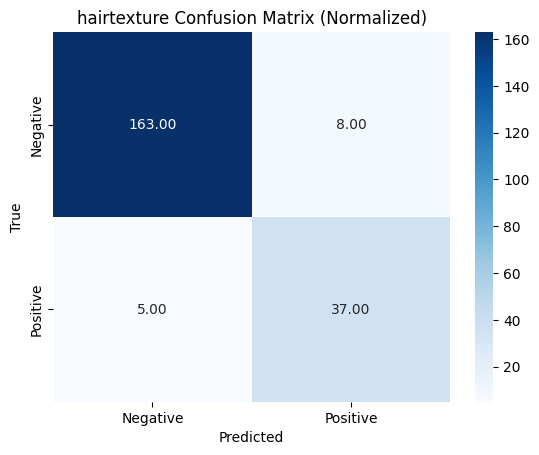

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_target, pred)
labels = ['Negative', 'Positive']  # 이진 분류 레이블
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
# title 에서 앞부분 본인 주제에 맞는 걸로 바꿔주세요.
plt.title('hairtexture Confusion Matrix (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()